# Flight Delay Analysis
This notebook analyzes flight delay data, including handling missing values, exploring delay patterns, and visualizing insights into delays by airline, seasonal trends, and on-time performance.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
flights_data = pd.read_csv('flights.csv')

# Display the first few rows of the dataset
flights_data.head()

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance,hour,minute
0,2013,1,1,517.0,2.0,830.0,11.0,UA,N14228,1545,EWR,IAH,227.0,1400,5.0,17.0
1,2013,1,1,533.0,4.0,850.0,20.0,UA,N24211,1714,LGA,IAH,227.0,1416,5.0,33.0
2,2013,1,1,542.0,2.0,923.0,33.0,AA,N619AA,1141,JFK,MIA,160.0,1089,5.0,42.0
3,2013,1,1,554.0,-6.0,812.0,-25.0,DL,N668DN,461,LGA,ATL,116.0,762,5.0,54.0
4,2013,1,1,554.0,-4.0,740.0,12.0,UA,N39463,1696,EWR,ORD,150.0,719,5.0,54.0


## Step 1: Handling Missing Values
We first identify and address missing values in the dataset to ensure data quality for analysis.

In [4]:
# Check for missing values
missing_values = flights_data.isnull().sum()
print("Missing Values:\n", missing_values)

# Check data types
data_types = flights_data.dtypes
print("\nData Types:\n", data_types)

# Handle missing values
flights_data = flights_data.dropna(subset=['arr_time', 'arr_delay'])  # Drop rows critical for analysis
flights_data['dep_time'] = flights_data['dep_time'].fillna(flights_data['dep_time'].median())
flights_data['dep_delay'] = flights_data['dep_delay'].fillna(flights_data['dep_delay'].median())
flights_data['air_time'] = flights_data.groupby('carrier')['air_time'].transform(lambda x: x.fillna(x.median()))
flights_data = flights_data.dropna(subset=['tailnum'])  # Non-essential rows dropped

# Convert columns to appropriate types
flights_data['hour'] = flights_data['hour'].fillna(0).astype(int)
flights_data['minute'] = flights_data['minute'].fillna(0).astype(int)

# Add derived columns
flights_data['dep_time_in_minutes'] = flights_data['hour'] * 60 + flights_data['minute']
flights_data['significant_delay'] = flights_data['arr_delay'] > 30

# Drop irrelevant columns
flights_data = flights_data.drop(columns=['year', 'month', 'day'])

# Save the cleaned data for reuse
flights_data.to_csv('cleaned_flights.csv', index=False)

Missing Values:
 year            0
month           0
day             0
dep_time     2336
dep_delay    2336
arr_time     2479
arr_delay    2827
carrier         0
tailnum      1433
flight          0
origin          0
dest            0
air_time     2827
distance        0
hour         2336
minute       2336
dtype: int64

Data Types:
 year           int64
month          int64
day            int64
dep_time     float64
dep_delay    float64
arr_time     float64
arr_delay    float64
carrier       object
tailnum       object
flight         int64
origin        object
dest          object
air_time     float64
distance       int64
hour         float64
minute       float64
dtype: object


## Step 2: Exploratory Data Analysis
We analyze basic statistics, explore distributions, and study patterns related to delays.

In [6]:
# Reload the cleaned dataset
flights_data = pd.read_csv('cleaned_flights.csv')

# Basic statistics for delays
delay_summary = flights_data[['dep_delay', 'arr_delay']].describe()
print("Summary Statistics for Delays:\n", delay_summary)

# Significant delay counts
significant_delay_count = flights_data['significant_delay'].value_counts()
print("\nSignificant Delay Count:\n", significant_delay_count)

Summary Statistics for Delays:
            dep_delay      arr_delay
count  157927.000000  157927.000000
mean        9.410101       2.094537
std        36.448570      41.479349
min       -33.000000     -75.000000
25%        -5.000000     -19.000000
50%        -2.000000      -7.000000
75%         6.000000       9.000000
max      1014.000000    1007.000000

Significant Delay Count:
 significant_delay
False    138579
True      19348
Name: count, dtype: int64


### Visualization: Distribution of Arrival Delays
We visualize the frequency of arrival delays to understand their spread.

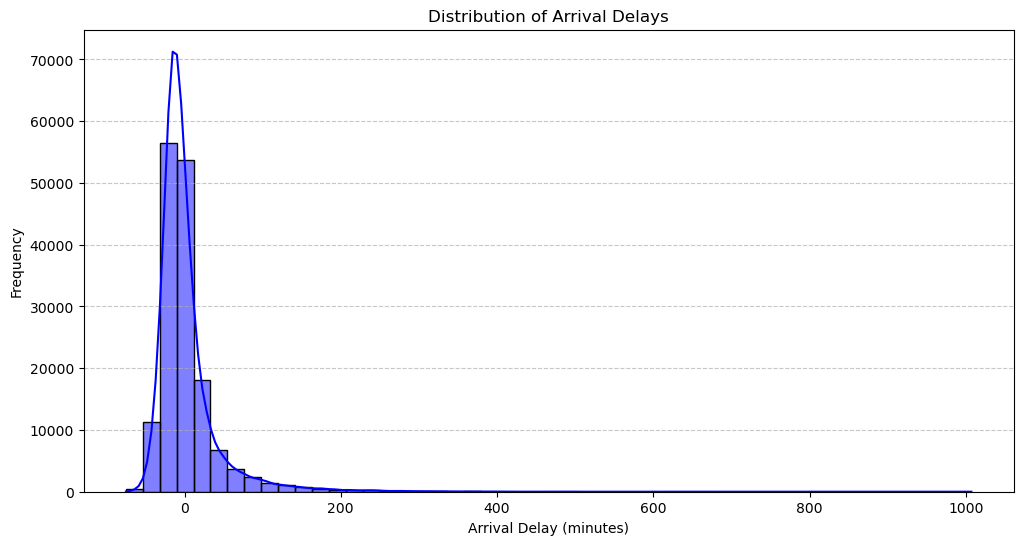

In [8]:
plt.figure(figsize=(12, 6))
sns.histplot(flights_data['arr_delay'], bins=50, kde=True, color='blue')
plt.title('Distribution of Arrival Delays')
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Step 3: Airline Analysis
### Average Delays by Airline
We compute and visualize average delays for each airline.

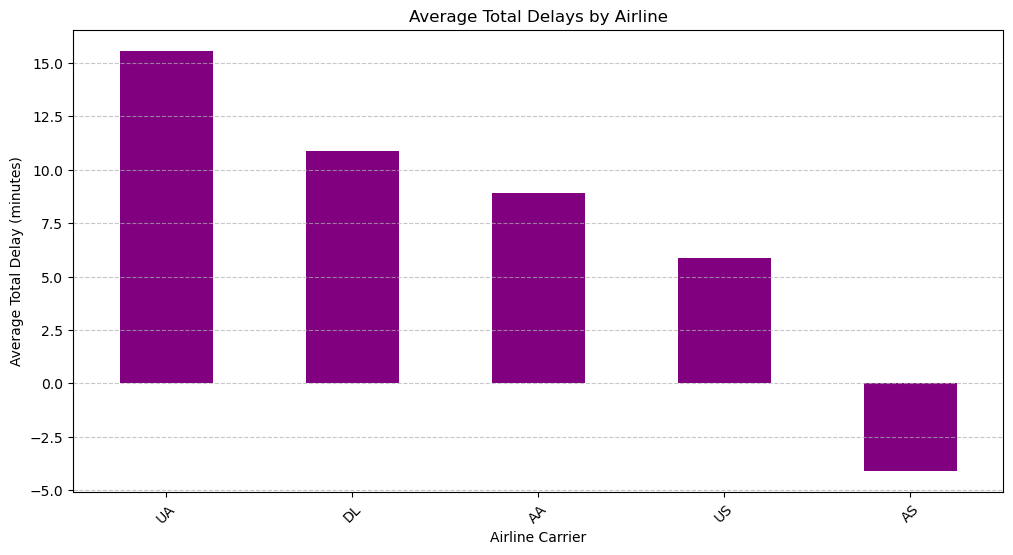

In [10]:
# Analyze delays by airline
carrier_delays = flights_data.groupby('carrier')[['dep_delay', 'arr_delay']].mean()
carrier_delays['total_delay'] = carrier_delays['dep_delay'] + carrier_delays['arr_delay']
carrier_delays = carrier_delays.sort_values('total_delay', ascending=False)

# Visualize total delays by airline
plt.figure(figsize=(12, 6))
carrier_delays['total_delay'].plot(kind='bar', color='purple')
plt.title('Average Total Delays by Airline')
plt.xlabel('Airline Carrier')
plt.ylabel('Average Total Delay (minutes)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

### On-Time Performance
We analyze and visualize on-time arrival and departure performance for each airline.

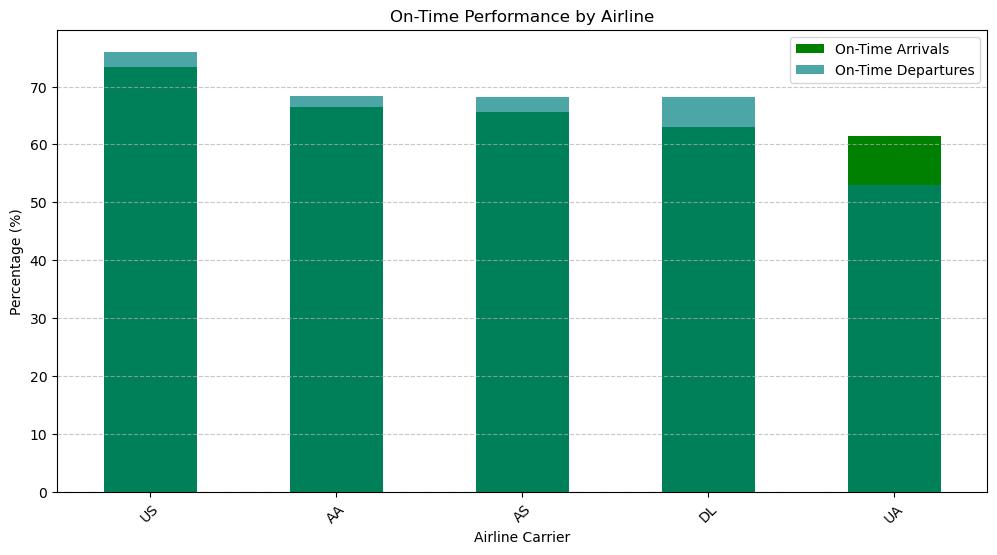

In [12]:
# On-time arrivals analysis
flights_data['on_time'] = flights_data['arr_delay'] <= 0
on_time_analysis = flights_data.groupby('carrier')['on_time'].sum()
on_time_percentage = (on_time_analysis / flights_data['carrier'].value_counts() * 100).sort_values(ascending=False)

# On-time departures analysis
flights_data['on_time_departure'] = flights_data['dep_delay'] <= 0
on_time_departure_analysis = flights_data.groupby('carrier')['on_time_departure'].sum()
on_time_departure_percentage = (on_time_departure_analysis / flights_data['carrier'].value_counts() * 100).sort_values(ascending=False)

# Visualize on-time performance
plt.figure(figsize=(12, 6))
on_time_percentage.plot(kind='bar', color='green', label='On-Time Arrivals')
on_time_departure_percentage.plot(kind='bar', color='teal', alpha=0.7, label='On-Time Departures')
plt.title('On-Time Performance by Airline')
plt.xlabel('Airline Carrier')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

## Step 4: Seasonal Trends
We explore monthly and weekly delay patterns to identify seasonal trends.

<Figure size 1000x600 with 0 Axes>

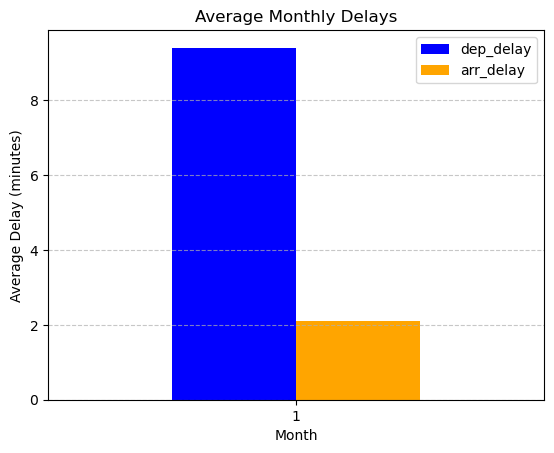

<Figure size 1000x600 with 0 Axes>

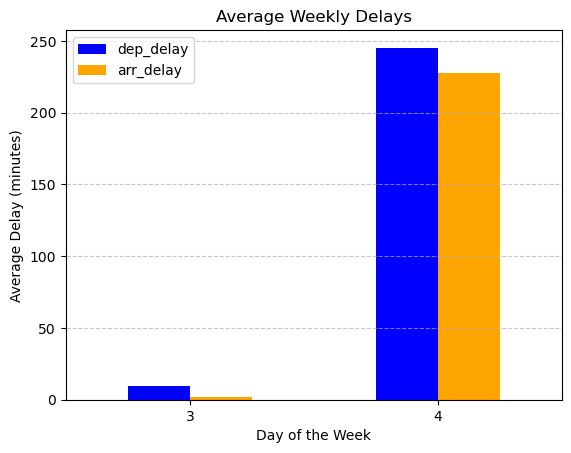

In [14]:
# Monthly and weekly trends
flights_data['month'] = pd.to_datetime(flights_data['dep_time_in_minutes'], unit='m').dt.month
flights_data['day_of_week'] = pd.to_datetime(flights_data['dep_time_in_minutes'], unit='m').dt.dayofweek

# Monthly trends
monthly_delays = flights_data.groupby('month')[['dep_delay', 'arr_delay']].mean()
plt.figure(figsize=(10, 6))
monthly_delays.plot(kind='bar', color=['blue', 'orange'])
plt.title('Average Monthly Delays')
plt.xlabel('Month')
plt.ylabel('Average Delay (minutes)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.show()

# Weekly trends
weekly_delays = flights_data.groupby('day_of_week')[['dep_delay', 'arr_delay']].mean()
plt.figure(figsize=(10, 6))
weekly_delays.plot(kind='bar', color=['blue', 'orange'])
plt.title('Average Weekly Delays')
plt.xlabel('Day of the Week')
plt.ylabel('Average Delay (minutes)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.show()